In [2]:
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import os
from datetime import datetime,date
from geopy.distance import geodesic
from tqdm import tqdm
import numpy as np
from matplotlib.ticker import PercentFormatter
from shapely import geometry
from PlaceIQ_process import all_path,aggragate_data,mkdir,process_org_file,create_fishnet
import pickle
import time

from shapely.geometry import Point, LineString

In [3]:
os.getcwd()

'/panfs/jay/groups/13/dizhu/ma000523/IIDS_intra_urban_scale_directional/Deep_learning_FR/visitation_data'

In [13]:
for i in tqdm(range(1,10)):
    t1 = 20210700+i
    t2 = 20210700+i+1
    path_current='dt='+str(t1)+'.csv'
    path_after='dt='+str(t2)+'.csv'
    df_current=pd.read_csv(path_current)
    df_after=pd.read_csv(path_after)
    date_current = datetime(2021, 7, i, 0, 0, 0)
    date_after = datetime(2021, 7, i+1, 0, 0, 0)
    unix_current=time.mktime(date_current.timetuple())
    unix_after=time.mktime(date_after.timetuple())
    #     print(unix_current,unix_after)
    df_current=df_current[df_current.unix_time>=unix_current]
    df_addition=df_after[df_after.unix_time<unix_after]
    df_new=pd.concat([df_current,df_addition])
    df_new.to_csv('correct_time/dt='+str(t1)+'.csv')

100%|██████████| 9/9 [00:54<00:00,  6.01s/it]


In [16]:
path_list=['correct_time/dt='+str(20210700+i)+'.csv' for i in range(1,10)]
# index=['20210717']
device_key_number=[]
visit_record_number=[]
Start_time=[]
End_time=[]
print(path_list)


for i in range(len(path_list)):
    df=pd.read_csv(path_list[i])
    device_key_number.append(len(df.device_key.unique()))
    visit_record_number.append(len(df))
    Start_time.append(df[df.unix_time==min(df.unix_time)].date_time.unique()[0])
    End_time.append(df[df.unix_time==max(df.unix_time)].date_time.unique()[0])

['correct_time/dt=20210701.csv', 'correct_time/dt=20210702.csv', 'correct_time/dt=20210703.csv', 'correct_time/dt=20210704.csv', 'correct_time/dt=20210705.csv', 'correct_time/dt=20210706.csv', 'correct_time/dt=20210707.csv', 'correct_time/dt=20210708.csv', 'correct_time/dt=20210709.csv']


In [17]:
visit_data_stat=pd.DataFrame({'Unique device number':device_key_number,
                              'Visit record number':visit_record_number,
                              'Start time':Start_time,'End time':End_time},index=index)
visit_data_stat

,Unique device number,Visit record number,Start time,End time
correct_time/20210701,101803,1268653,2021-07-01 00:00:00,2021-07-01 23:59:59
correct_time/20210702,97052,1187509,2021-07-02 00:00:00,2021-07-02 23:59:59
correct_time/20210703,84835,1018622,2021-07-03 00:00:00,2021-07-03 23:59:59
correct_time/20210704,82295,927536,2021-07-04 00:00:00,2021-07-04 23:59:59
correct_time/20210705,94933,956044,2021-07-05 00:00:00,2021-07-05 23:59:59
correct_time/20210706,98000,1055542,2021-07-06 00:00:00,2021-07-06 23:59:59
correct_time/20210707,100374,1200774,2021-07-07 00:00:00,2021-07-07 23:59:59
correct_time/20210708,102192,1251050,2021-07-08 00:00:01,2021-07-08 23:59:59
correct_time/20210709,103683,1321733,2021-07-09 00:00:00,2021-07-09 23:59:59


In [23]:
boundary_path='fishnet_3km.json'
boundary=gpd.read_file(boundary_path)
print(boundary.crs)
# boundary_26915 = boundary.to_crs('EPSG:26915')
# fishnet_3km=create_fishnet(boundary_26915,3000)
boundary

epsg:26915


,geometry
0,"POLYGON ((476967.132 4924212.791, 476967.132 4..."
1,"POLYGON ((479967.132 4924212.791, 479967.132 4..."
2,"POLYGON ((482967.132 4924212.791, 482967.132 4..."
3,"POLYGON ((485967.132 4924212.791, 485967.132 4..."
4,"POLYGON ((488967.132 4924212.791, 488967.132 4..."
...,...
920,"POLYGON ((485967.132 5026212.791, 485967.132 5..."
921,"POLYGON ((488967.132 5026212.791, 488967.132 5..."
922,"POLYGON ((491967.132 5026212.791, 491967.132 5..."
923,"POLYGON ((494967.132 5026212.791, 494967.132 5..."


In [3]:
# fishnet_3km.to_file("fishnet_3km.json", driver="GeoJSON")
# boundary=gpd.read_file(boundary_path)

In [ ]:
for i in range(10):
    df=pd.read_csv(path_list[i])
    df_sort=df.sort_values(by=['device_key', 'unix_time'])
    visit2traj=pd.DataFrame(columns=['device_key', 'visit_start_lat',
                                     'visit_start_lon', 'visit_end_lat', 
                                     'visit_end_lon'])
    device_key=[]
    visit_start_lat=[]
    visit_start_lon=[]
    visit_end_lat=[]
    visit_end_lon=[]
    for i in tqdm(range(len(df_sort))):
        if i+1==len(df_sort):
            break
        if df_sort.iloc[i,:].device_key==df_sort.iloc[i+1,:].device_key:
            device_key.append(df_sort.iloc[i,:].device_key)
            visit_start_lat.append(df_sort.iloc[i,:].visit_centroid_lat)
            visit_start_lon.append(df_sort.iloc[i,:].visit_centroid_lon)
            visit_end_lat.append(df_sort.iloc[i+1,:].visit_centroid_lat)
            visit_end_lon.append(df_sort.iloc[i+1,:].visit_centroid_lon)
    visit2traj['device_key']=device_key
    visit2traj['visit_start_lat']=visit_start_lat
    visit2traj['visit_start_lon']=visit_start_lon
    visit2traj['visit_end_lat']=visit_end_lat
    visit2traj['visit_end_lon']=visit_end_lon
    visit2traj.to_csv('visit2traj/dt='+str(20210700+i)+'_visit2traj.csv',index = False)
# visit2traj_number.append(len(visit2traj))

 12%|█▏        | 148839/1268653 [01:19<09:59, 1868.02it/s]

In [50]:
visit2traj.to_csv('demo_data/dt=20210717_visit2traj.csv')
visit2traj

,device_key,visit_start_lat,visit_start_lon,visit_end_lat,visit_end_lon
0,422002,44.832745,-93.035300,44.920800,-93.104600
1,422002,44.920800,-93.104600,44.921000,-93.103600
2,422002,44.921000,-93.103600,44.742060,-93.501130
3,422002,44.742060,-93.501130,44.746500,-93.495300
4,422002,44.746500,-93.495300,44.746400,-93.297300
...,...,...,...,...,...
1177238,135743453073,44.781954,-93.244710,44.790915,-93.240270
1177239,135743453073,44.790915,-93.240270,44.790400,-93.241500
1177240,135743567199,45.126005,-93.358515,45.137800,-93.406800
1177241,135743567199,45.137800,-93.406800,45.139300,-93.407300


In [72]:
len(visit2traj.device_key.unique())

93800

In [62]:
visit_data=pd.read_csv('demo_data/dt=20210717.csv')
visit_data

,Unnamed: 0,device_key,date_time,unix_time,visit_centroid_lat,visit_centroid_lon
0,3,128904823101,2021-07-17 16:46:34,1626558394,45.136200,-93.172200
1,4,133470486908,2021-07-17 10:33:24,1626536004,45.137918,-93.178122
2,5,135041522300,2021-07-17 18:33:19,1626564799,45.132475,-93.179415
3,6,135669457748,2021-07-17 09:24:10,1626531850,45.091673,-93.228117
4,7,135643819013,2021-07-17 04:47:32,1626515252,45.092490,-93.231360
...,...,...,...,...,...,...
1276548,1187141,135667515004,2021-07-17 22:45:05,1626579905,44.951684,-93.419871
1276549,1187142,135549050326,2021-07-17 20:57:07,1626573427,44.951000,-93.413500
1276550,1187153,135725922046,2021-07-17 22:16:08,1626578168,44.971700,-93.083800
1276551,1187160,117978194071,2021-07-17 20:21:31,1626571291,44.954400,-93.400000


In [70]:
# len(visit_data.device_key.unique())
grouped = visit_data.groupby('device_key')

for name, group in grouped:
    if len(group)<2:
        print(1)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [53]:
line_geometry=[]
for index, traj in tqdm(visit2traj.iterrows()):
#     print(traj.visit_start_lon)
#     break
    line_geometry.append(LineString([(traj.visit_start_lon,traj.visit_start_lat),
                                     (traj.visit_end_lon,traj.visit_end_lat)]))
file_name_gdf=gpd.GeoDataFrame(visit2traj, geometry=line_geometry)


1177243it [01:09, 16865.69it/s]


In [59]:
# file_name_gdf.crs='EPSG:4326'
# boundary.crs
file_name_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

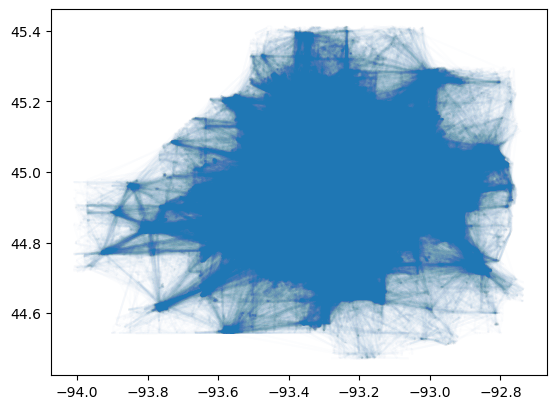

In [30]:
file_name_gdf.plot(alpha=0.01)

In [60]:
file_name_gdf.to_file('demo_data/dt=20210717_visit2traj_shapefile.shp')

/var/tmp/pbs.69908.compute.cla/ipykernel_100576/2902099177.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  file_name_gdf.to_file('demo_data/dt=20210717_visit2traj_shapefile.shp')


<AxesSubplot: >

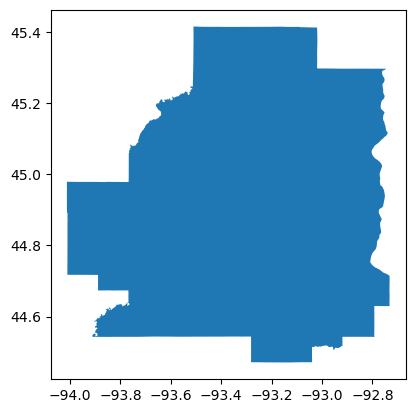

In [44]:
boundary_outline=boundary.copy()
boundary_outline=boundary_outline.dissolve(by='State')
boundary_outline.plot()

In [45]:
boundary_outline.to_file('demo_data/TCMA_outline.shp')

/var/tmp/pbs.69908.compute.cla/ipykernel_100576/3975693314.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  boundary_outline.to_file('demo_data/TCMA_outline.shp')


In [6]:
df=pd.read_csv('demo_data/dt=20210717_visit2traj.csv')

In [10]:
df.device_key.value_counts()[:10]

/var/tmp/pbs.70519.compute.cla/ipykernel_31541/2787591288.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df.device_key.value_counts()[:10]


135289932660    184
45062041428     178
135653677369    165
129784504260    158
103325974814    155
67582746646     154
20517454038     153
134627057268    145
135012664593    140
61661561380     139
Name: device_key, dtype: int64